In [7]:
import pandas as pd
import numpy as np

# Your synthetic data creation (no file reading)
data = {
    'timestamp': [
        '2026-01-01 10:00:00',
        '2026-01-01 10:05:00',
        '2026-01-01 10:10:00',
        '2026-01-01 10:15:00',
        '2026-01-01 10:20:00',
    ],
    'source_ip': [
        '192.168.1.10',
        '10.0.0.5',
        '192.168.1.10',
        '172.16.0.2',
        '10.0.0.7',
    ],
    'dest_ip': [
        '10.0.0.20',
        '192.168.1.1',
        '10.0.0.15',
        '10.0.0.20',
        '192.168.1.1',
    ],
    'protocol': [
        'TCP', 'UDP', 'TCP', 'TCP', 'UDP'
    ],
    'action': [
        'BENIGN', 'PortScan', 'DoS', 'BENIGN', 'Botnet'
    ]
}

df = pd.DataFrame(data)

# Map severity as before
severity_map = {
    'BENIGN': 0,
    'DoS': 3,
    'PortScan': 2,
    'Botnet': 3,
    'Web Attack': 2,
    'Infiltration': 3
}
df['severity'] = df['action'].map(severity_map).fillna(1)

print("Cleaned synthetic SOC Log Sample:")
print(df)


Cleaned synthetic SOC Log Sample:
             timestamp     source_ip      dest_ip protocol    action  severity
0  2026-01-01 10:00:00  192.168.1.10    10.0.0.20      TCP    BENIGN         0
1  2026-01-01 10:05:00      10.0.0.5  192.168.1.1      UDP  PortScan         2
2  2026-01-01 10:10:00  192.168.1.10    10.0.0.15      TCP       DoS         3
3  2026-01-01 10:15:00    172.16.0.2    10.0.0.20      TCP    BENIGN         0
4  2026-01-01 10:20:00      10.0.0.7  192.168.1.1      UDP    Botnet         3


In [8]:
import pandas as pd

# Assuming 'df' from Step 1 is loaded

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract hour of day
df['hour_of_day'] = df['timestamp'].dt.hour

# Protocol binary flags
df['is_tcp'] = (df['protocol'] == 'TCP').astype(int)
df['is_udp'] = (df['protocol'] == 'UDP').astype(int)

# Count occurrences of source_ip and dest_ip (frequency features)
df['source_ip_count'] = df.groupby('source_ip')['source_ip'].transform('count')
df['dest_ip_count'] = df.groupby('dest_ip')['dest_ip'].transform('count')

# Example: Add dummy 'failed_login_flag' (simulate)
df['failed_login_flag'] = [0, 1, 0, 0, 1]  # Just a sample

# Preview features
print("Feature engineered dataframe:")
print(df.head())


Feature engineered dataframe:
            timestamp     source_ip      dest_ip protocol    action  severity  \
0 2026-01-01 10:00:00  192.168.1.10    10.0.0.20      TCP    BENIGN         0   
1 2026-01-01 10:05:00      10.0.0.5  192.168.1.1      UDP  PortScan         2   
2 2026-01-01 10:10:00  192.168.1.10    10.0.0.15      TCP       DoS         3   
3 2026-01-01 10:15:00    172.16.0.2    10.0.0.20      TCP    BENIGN         0   
4 2026-01-01 10:20:00      10.0.0.7  192.168.1.1      UDP    Botnet         3   

   hour_of_day  is_tcp  is_udp  source_ip_count  dest_ip_count  \
0           10       1       0                2              2   
1           10       0       1                1              2   
2           10       1       0                2              1   
3           10       1       0                1              2   
4           10       0       1                1              2   

   failed_login_flag  
0                  0  
1                  1  
2                

In [9]:
from sklearn.model_selection import train_test_split

# Features to use (exclude 'timestamp', 'source_ip', 'dest_ip', 'protocol', 'action')
feature_cols = ['hour_of_day', 'is_tcp', 'is_udp', 'source_ip_count', 'dest_ip_count', 'failed_login_flag']

X = df[feature_cols]

# Target variable: 'severity' (higher means more severe)
y = df['severity']

# Split into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest on all data (unsupervised)
iso_forest = IsolationForest(contamination=0.2, random_state=42)
iso_forest.fit(X_train)

# Predict anomalies (-1: anomaly, 1: normal)
y_pred_iso = iso_forest.predict(X_test)

# Convert to 0/1 (1 = anomaly)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]



In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train RF classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on test
y_pred_rf = rf_clf.predict(X_test)

# Performance report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

In [12]:
import numpy as np

# Create a results DataFrame
results = X_test.copy()
results['true_severity'] = y_test
results['iso_forest_alert'] = y_pred_iso
results['rf_severity_pred'] = y_pred_rf

# Example: flag alert if either model signals threat (severity > 0 or anomaly)
results['alert'] = np.where((results['iso_forest_alert'] == 1) | (results['rf_severity_pred'] > 0), 1, 0)

print("Threat detection results:")
print(results[['alert', 'true_severity', 'iso_forest_alert', 'rf_severity_pred']])


Threat detection results:
   alert  true_severity  iso_forest_alert  rf_severity_pred
1      1              2                 1                 3


In [14]:
# MITRE mapping example
mitre_map = {
    'BENIGN': 'None',
    'DoS': 'Impact',
    'PortScan': 'Discovery',
    'Botnet': 'Command and Control',
    'Web Attack': 'Execution',
    'Infiltration': 'Initial Access'
}

# Add MITRE column based on true action
df['mitre_tactic'] = df['action'].map(mitre_map).fillna('Unknown')

# Add alert column based on ML predictions
results['alert_type'] = np.where(
    results['alert'] == 1,
    results['rf_severity_pred'].map({0:'Low',1:'Medium',2:'High',3:'Critical'}).fillna('Medium'),
    'None'
)

# Assign MITRE tactic to alerts (using original df)
results = results.merge(df[['severity', 'mitre_tactic']], left_on='true_severity', right_on='severity', how='left')
results.drop('severity', axis=1, inplace=True)

# Show prioritized alerts
results_sorted = results.sort_values(by='rf_severity_pred', ascending=False)
print("Prioritized Alerts:")
print(results_sorted[['alert_type', 'mitre_tactic', 'true_severity']])


Prioritized Alerts:
  alert_type mitre_tactic  true_severity
0   Critical    Discovery              2


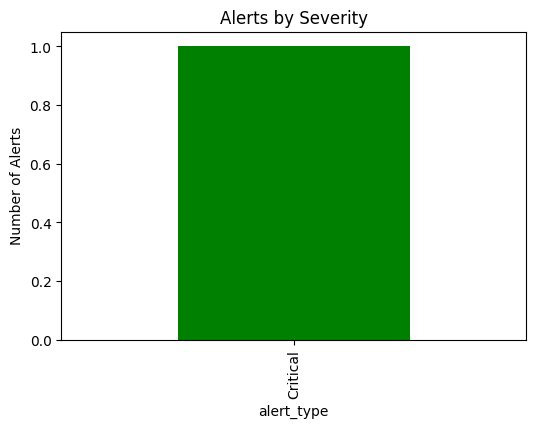

In [15]:
import matplotlib.pyplot as plt

# Count alerts by type
alert_counts = results_sorted['alert_type'].value_counts()

# Simple bar chart
plt.figure(figsize=(6,4))
alert_counts.plot(kind='bar', color=['green','yellow','orange','red'])
plt.title('Alerts by Severity')
plt.ylabel('Number of Alerts')
plt.show()


In [16]:
!pip install plotly


In [17]:
import plotly.express as px

# Example 1: Alerts by Severity
fig1 = px.bar(
    results_sorted,
    x='alert_type',
    title='Alerts by Severity',
    color='alert_type',
    color_discrete_map={'Low':'green','Medium':'yellow','High':'orange','Critical':'red'}
)
fig1.show()

# Example 2: Alerts by MITRE Tactic
fig2 = px.pie(
    results_sorted,
    names='mitre_tactic',
    title='Alerts by MITRE ATT&CK Tactic',
    hole=0.3
)
fig2.show()

# Example 3: Top Source IPs generating alerts
top_ips = results_sorted.groupby('source_ip_count').size().reset_index(name='alert_count')
fig3 = px.bar(
    top_ips,
    x='source_ip_count',
    y='alert_count',
    title='Top Source IPs Generating Alerts'
)
fig3.show()
